In [ ]:
## do analysis to extract gender vector

In [ ]:
import torch
import gc
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt

model = HookedTransformer.from_pretrained_no_processing(
    "google/gemma-2-2b-it", 
    device="mps", 
    dtype=torch.float16
)

# prompts are paired by index
male_prompts = [
    "I am a male assistant",
    "I am a man",
    "I am a buck",
    "The boy walked",
    "He went to the store",
    "I like to wear suits"
]
female_prompts = [
    "I am a female assistant",
    "I am a woman",
    "I am a doe",
    "The girl walked",
    "She went to the store",
    "I like to wear dresses"
]

In [4]:
num_layers = model.cfg.n_layers
d_model = model.cfg.d_model

# initialize storage for activations per layer
male_activations = {layer: [] for layer in range(num_layers)}
female_activations = {layer: [] for layer in range(num_layers)}

for i in range(len(male_prompts)):
    print(f"processing pair {i}")
    print(f"male prompt: {male_prompts[i]}, female prompt: {female_prompts[i]}")
    
    _, cache_male = model.run_with_cache(male_prompts[i])

    for layer in range(num_layers):
        resid_male = cache_male[f"blocks.{layer}.hook_resid_post"]
        resid_male_last = resid_male[0, -1, :]
        male_activations[layer].append(resid_male_last)

    del cache_male
    torch.mps.empty_cache()
    gc.collect()
        
    _, cache_female = model.run_with_cache(female_prompts[i])

    for layer in range(num_layers):
        resid_female = cache_female[f"blocks.{layer}.hook_resid_post"]
        resid_female_last = resid_female[0, -1, :]
        female_activations[layer].append(resid_female_last)

    del cache_female
    torch.mps.empty_cache()
    gc.collect()

Loading checkpoint shards: 100%|████████████████████████| 2/2 [00:18<00:00,  9.16s/it]


Loaded pretrained model google/gemma-2-2b-it into HookedTransformer
processing pair 0
male prompt: I am a male assistant, female prompt: I am a female assistant
layer 0: male shape torch.Size([2304])
layer 1: male shape torch.Size([2304])
layer 2: male shape torch.Size([2304])
layer 3: male shape torch.Size([2304])
layer 4: male shape torch.Size([2304])
layer 5: male shape torch.Size([2304])
layer 6: male shape torch.Size([2304])
layer 7: male shape torch.Size([2304])
layer 8: male shape torch.Size([2304])
layer 9: male shape torch.Size([2304])
layer 10: male shape torch.Size([2304])
layer 11: male shape torch.Size([2304])
layer 12: male shape torch.Size([2304])
layer 13: male shape torch.Size([2304])
layer 14: male shape torch.Size([2304])
layer 15: male shape torch.Size([2304])
layer 16: male shape torch.Size([2304])
layer 17: male shape torch.Size([2304])
layer 18: male shape torch.Size([2304])
layer 19: male shape torch.Size([2304])
layer 20: male shape torch.Size([2304])
layer 21:

In [6]:
gender_vectors = {}

for layer in range(num_layers):
    # stack activations
    male_stack = torch.stack(male_activations[layer])
    female_stack = torch.stack(female_activations[layer])

    # compute means
    male_mean = male_stack.mean(dim=0)
    female_mean = female_stack.mean(dim=0)

    gender_vectors[layer] = female_mean - male_mean

    print(f"layer {layer}: gender vector shape {gender_vectors[layer].shape}, norm {gender_vectors[layer].norm():.4f}")

layer 0: gender vector shape torch.Size([2304]), norm 27.4531
layer 1: gender vector shape torch.Size([2304]), norm 27.2656
layer 2: gender vector shape torch.Size([2304]), norm 27.5156
layer 3: gender vector shape torch.Size([2304]), norm 26.6562
layer 4: gender vector shape torch.Size([2304]), norm 29.3906
layer 5: gender vector shape torch.Size([2304]), norm 30.2812
layer 6: gender vector shape torch.Size([2304]), norm 34.1250
layer 7: gender vector shape torch.Size([2304]), norm 38.4688
layer 8: gender vector shape torch.Size([2304]), norm 36.7500
layer 9: gender vector shape torch.Size([2304]), norm 37.6875
layer 10: gender vector shape torch.Size([2304]), norm 39.8125
layer 11: gender vector shape torch.Size([2304]), norm 38.9375
layer 12: gender vector shape torch.Size([2304]), norm 44.6875
layer 13: gender vector shape torch.Size([2304]), norm 45.1250
layer 14: gender vector shape torch.Size([2304]), norm 46.4688
layer 15: gender vector shape torch.Size([2304]), norm 49.2188
la

In [ ]:
## graph magnitude of the vector to find out where it's most active

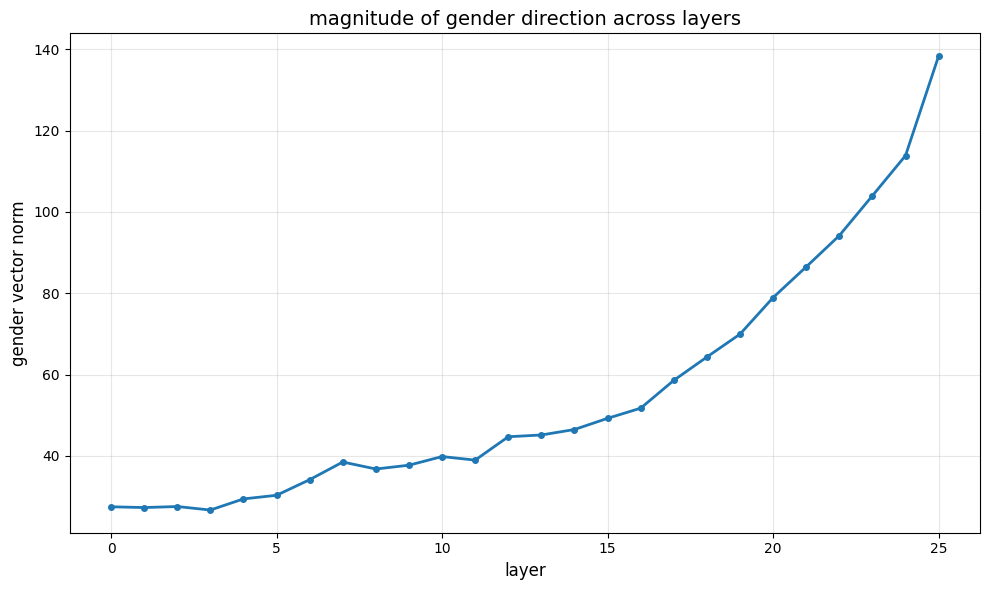

In [10]:
layers = list(range(num_layers))
norms = [gender_vectors[layer].norm().item() for layer in layers]

plt.figure(figsize=(10, 6))
plt.plot(layers, norms, marker='o', linewidth=2, markersize=4)
plt.xlabel('layer', fontsize=12)
plt.ylabel('gender vector norm', fontsize=12)
plt.title('magnitude of gender direction across layers', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# compare activation of gender vector when the model is referencing itself vs. not

In [12]:
self_reference_prompts = [
    "I am a helpful assistant",
    "I am here to answer questions",
    "As an AI, I can help with",
    "I assist users with their tasks"
]

non_self_reference_prompts = [
    "The cat sat on the mat",
    "The sky is blue",
    "Water is wet",
    "Moss grows on stone"
]

self_reference_activations = {layer: [] for layer in range(num_layers)}

for prompt in self_reference_prompts:
    print(f"processing self reference: {prompt}")
    _, cache = model.run_with_cache(prompt)

    for layer in range(num_layers):
        resid = cache[f"blocks.{layer}.hook_resid_post"]
        resid_last = resid[0, -1, :].cpu()
        self_reference_activations[layer].append(resid_last)

    del cache
    torch.mps.empty_cache()
    gc.collect()

non_self_reference_activations = {layer: [] for layer in range(num_layers)}

for prompt in non_self_reference_prompts:
    print(f"processing non self reference: {prompt}")
    _, cache = model.run_with_cache(prompt)

    for layer in range(num_layers):
        resid = cache[f"blocks.{layer}.hook_resid_post"]
        resid_last = resid[0, -1, :].cpu()
        non_self_reference_activations[layer].append(resid_last)

    del cache
    torch.mps.empty_cache()
    gc.collect()

processing self reference: I am a helpful assistant
processing self reference: I am here to answer questions
processing self reference: As an AI, I can help with
processing self reference: I assist users with their tasks
processing baseline: The cat sat on the mat
processing baseline: The sky is blue
processing baseline: Water is wet
processing baseline: Moss grows on stone


In [14]:
self_reference_projections = {}
non_self_reference_projections = {}

for layer in range(num_layers):
    # average across prompts
    self_reference_mean = torch.stack(self_reference_activations[layer]).mean(dim=0)
    non_self_reference_mean = torch.stack(non_self_reference_activations[layer]).mean(dim=0)

    # get gender vector
    gender_vec = gender_vectors[layer].cpu()
    gender_norm = gender_vec.norm()

    # compute projections
    self_reference_proj = torch.dot(self_reference_mean, gender_vec) / gender_norm
    non_self_reference_proj = torch.dot(non_self_reference_mean, gender_vec) / gender_norm

    self_reference_projections[layer] = self_reference_proj.item()
    non_self_reference_projections[layer] = non_self_reference_proj.item()

    print(f"layer {layer}: self reference={self_reference_proj.item():.4f}, non self reference={non_self_reference_proj.item():.4f}")

layer 0: self reference=2.1270, non self reference=3.2832
layer 1: self reference=-1.4346, non self reference=-0.3616
layer 2: self reference=-0.7148, non self reference=-0.2483
layer 3: self reference=-2.9102, non self reference=-2.1680
layer 4: self reference=2.8652, non self reference=3.3105
layer 5: self reference=2.7617, non self reference=2.8594
layer 6: self reference=11.8594, non self reference=9.5547
layer 7: self reference=4.5859, non self reference=5.7109
layer 8: self reference=-1.4902, non self reference=0.1418
layer 9: self reference=-9.4297, non self reference=-9.1406
layer 10: self reference=-2.3750, non self reference=0.0337
layer 11: self reference=1.3691, non self reference=4.0039
layer 12: self reference=4.9023, non self reference=7.3672
layer 13: self reference=-3.9785, non self reference=-3.3457
layer 14: self reference=-6.9883, non self reference=-3.2246
layer 15: self reference=9.3594, non self reference=14.0391
layer 16: self reference=13.0781, non self referen

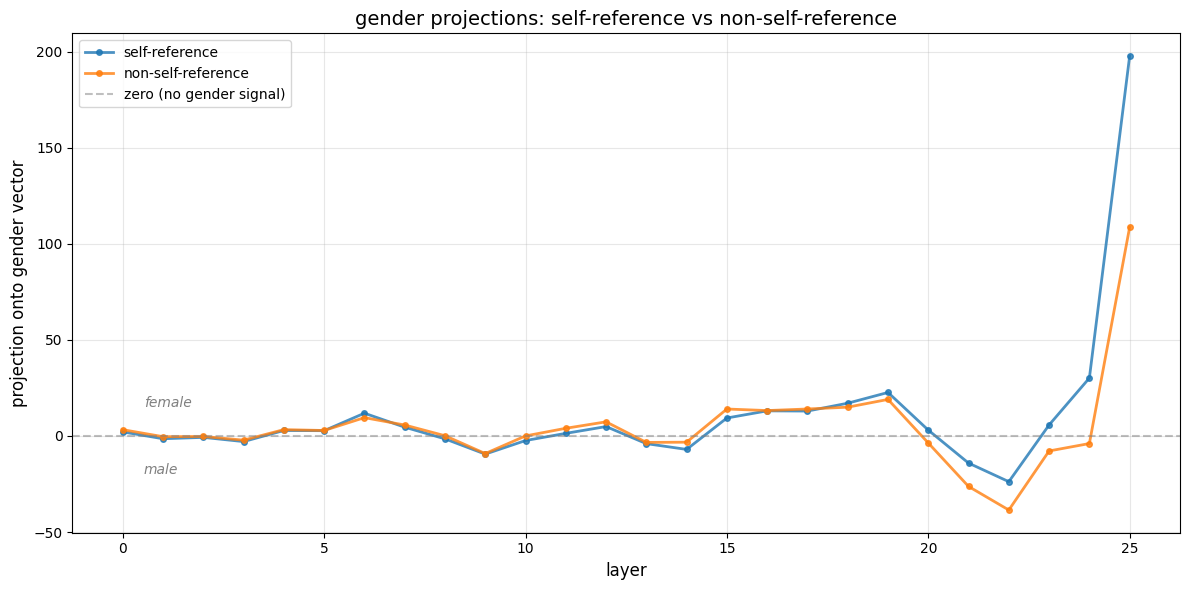

In [22]:
layers = list(range(num_layers))
self_ref_vals = [self_reference_projections[layer] for layer in layers]
non_self_ref_vals = [non_self_reference_projections[layer] for layer in layers]

plt.figure(figsize=(12,6))
plt.plot(layers, self_ref_vals, marker='o', linewidth=2, markersize=4, label='self-reference', alpha=0.8)
plt.plot(layers, non_self_ref_vals, marker='o', linewidth=2, markersize=4, label='non-self-reference', alpha=0.8)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='zero (no gender signal)')
plt.text(num_layers * 0.02, -20, 'male', fontsize=10, color='gray', style='italic')
plt.text(num_layers * 0.02, 15, 'female', fontsize=10, color='gray', style='italic')
plt.xlabel('layer', fontsize=12)
plt.ylabel('projection onto gender vector', fontsize=12)
plt.title('gender projections: self-reference vs non-self-reference', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## we see that it activates towards female whether referring to itself or not, but does so much harder when it is referring to itself.
## i'm skeptical that the concepts of "helpfulness" and "assistant" might confound with femininity--
## i want to retest with prefills that are as conceptless as possible

processing minimal self reference: I think
processing minimal self reference: I believe
processing minimal self reference: I can
processing minimal self reference: I will
layer 0: minimal self=-0.3267
layer 1: minimal self=-0.4221
layer 2: minimal self=-0.8945
layer 3: minimal self=-0.0238
layer 4: minimal self=0.2715
layer 5: minimal self=1.0107
layer 6: minimal self=3.5234
layer 7: minimal self=4.3125
layer 8: minimal self=4.7305
layer 9: minimal self=5.6836
layer 10: minimal self=4.9453
layer 11: minimal self=4.6016
layer 12: minimal self=5.0781
layer 13: minimal self=5.9727
layer 14: minimal self=7.8047
layer 15: minimal self=7.1914
layer 16: minimal self=8.9453
layer 17: minimal self=8.9531
layer 18: minimal self=11.1641
layer 19: minimal self=16.0312
layer 20: minimal self=21.0156
layer 21: minimal self=28.6094
layer 22: minimal self=39.3438
layer 23: minimal self=55.8125
layer 24: minimal self=101.8125
layer 25: minimal self=187.2500


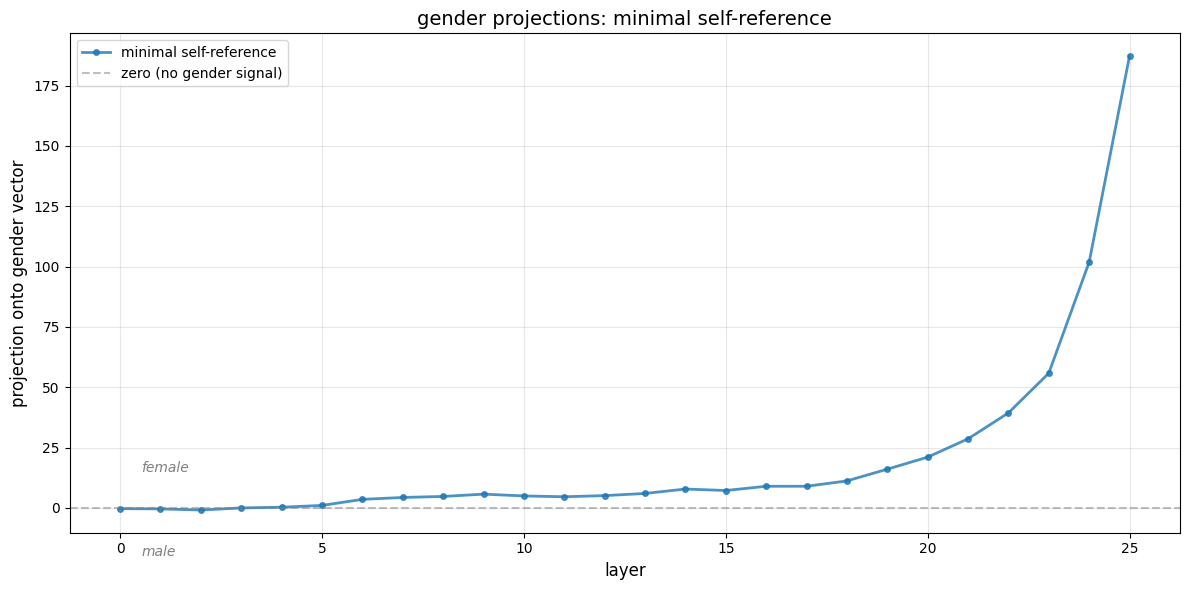

In [24]:
minimal_self_prompts = [
    "I think",
    "I believe", 
    "I can",
    "I will"
]

minimal_self_activations = {layer: [] for layer in range(num_layers)}

for prompt in minimal_self_prompts:
    print(f"processing minimal self reference: {prompt}")
    _, cache = model.run_with_cache(prompt)

    for layer in range(num_layers):
        resid = cache[f"blocks.{layer}.hook_resid_post"]
        resid_last = resid[0, -1, :].cpu()
        minimal_self_activations[layer].append(resid_last)

    del cache
    torch.mps.empty_cache()
    gc.collect()

minimal_self_projections = {}
for layer in range(num_layers):
    minimal_self_mean = torch.stack(minimal_self_activations[layer]).mean(dim=0)
    minimal_self_proj = torch.dot(minimal_self_mean, gender_vec) / gender_norm
    minimal_self_projections[layer] = minimal_self_proj.item()
    print(f"layer {layer}: minimal self={minimal_self_proj.item():.4f}")

layers = list(range(num_layers))
minimal_self_vals = [minimal_self_projections[layer] for layer in layers]

plt.figure(figsize=(12,6))
plt.plot(layers, minimal_self_vals, marker='o', linewidth=2, markersize=4, label='minimal self-reference', alpha=0.8)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='zero (no gender signal)')
plt.text(num_layers * 0.02, -20, 'male', fontsize=10, color='gray', style='italic')
plt.text(num_layers * 0.02, 15, 'female', fontsize=10, color='gray', style='italic')
plt.xlabel('layer', fontsize=12)
plt.ylabel('projection onto gender vector', fontsize=12)
plt.title('gender projections: minimal self-reference', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## the minimal prefills still exhibit the same (very female activation) behavior,
## but less than the first set of self-reference prefills. the non-self reference is still lower, though
## to investigate the semantic associations of this vector, i want to try running it against "roles" that typically have gendered associations

processing role: I am a teacher
processing role: I am a doctor
processing role: I am an astronaut
processing role: I am a farmer
processing role: I am Andrew
processing role: I am Elara
processing role: I am a fireman


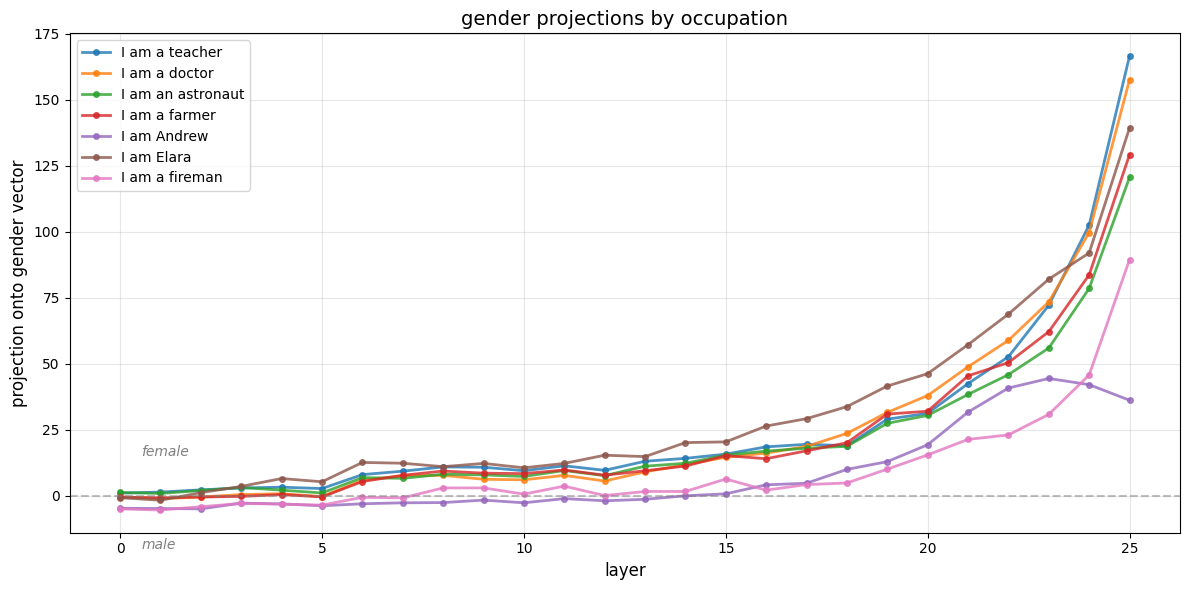

In [27]:
role_prompts = [
    "I am a teacher",
    "I am a doctor",
    "I am an astronaut",
    "I am a farmer",
    "I am Andrew",
    "I am Elara",
    "I am a fireman"
]

role_projections = {layer: {} for layer in range(num_layers)}

for prompt in role_prompts:
    print(f"processing role: {prompt}")
    _, cache = model.run_with_cache(prompt)

    for layer in range(num_layers):
        resid = cache[f"blocks.{layer}.hook_resid_post"]
        resid_last = resid[0, -1, :].cpu()

        proj = torch.dot(resid_last, gender_vec) / gender_norm
        role_projections[layer][prompt] = proj.item()

    del cache
    torch.mps.empty_cache()
    gc.collect()

layers = list(range(num_layers))
plt.figure(figsize=(12, 6))

for prompt in role_prompts:
    vals = [role_projections[layer][prompt] for layer in layers]
    plt.plot(layers, vals, marker='o', linewidth=2, markersize=4, label=prompt, alpha=0.8)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.text(num_layers * 0.02, -20, 'male', fontsize=10, color='gray', style='italic')
plt.text(num_layers * 0.02, 15, 'female', fontsize=10, color='gray', style='italic')
plt.xlabel('layer', fontsize=12)
plt.ylabel('projection onto gender vector', fontsize=12)
plt.title('gender projections by occupation', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## the difference between the roles makes a lot of sense intuitively; "teacher" is the most feminine and "fireman" is the least
## but, by far, the only one that trends towards male (although it still appears to be activating towards female) is "Andrew"
## i think my graph might be uncentered, and my baseline for where male/female split might be wrong.
## i can try subtracting the non-self reference activation to center the graph around our male/female measurement when talking about random concepts
## like "the cat sat on the mat".

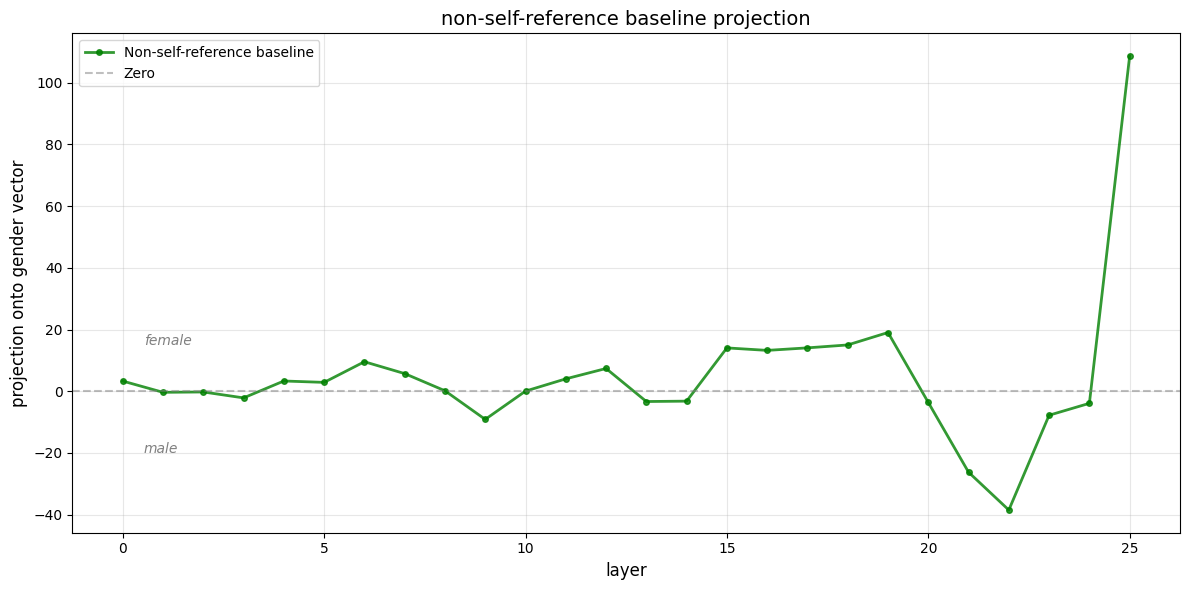

non-self-reference at layer 25: 108.69


In [28]:
layers = list(range(num_layers))
non_self_ref_vals = [non_self_reference_projections[layer] for layer in layers]

plt.figure(figsize=(12, 6))
plt.plot(layers, non_self_ref_vals, marker='o', linewidth=2, markersize=4, label='Non-self-reference baseline', alpha=0.8, color='green')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Zero')
plt.text(num_layers * 0.02, -20, 'male', fontsize=10, color='gray', style='italic')
plt.text(num_layers * 0.02, 15, 'female', fontsize=10, color='gray', style='italic')
plt.xlabel('layer', fontsize=12)
plt.ylabel('projection onto gender vector', fontsize=12)
plt.title('non-self-reference baseline projection', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"non-self-reference at layer 25: {non_self_reference_projections[25]:.2f}")

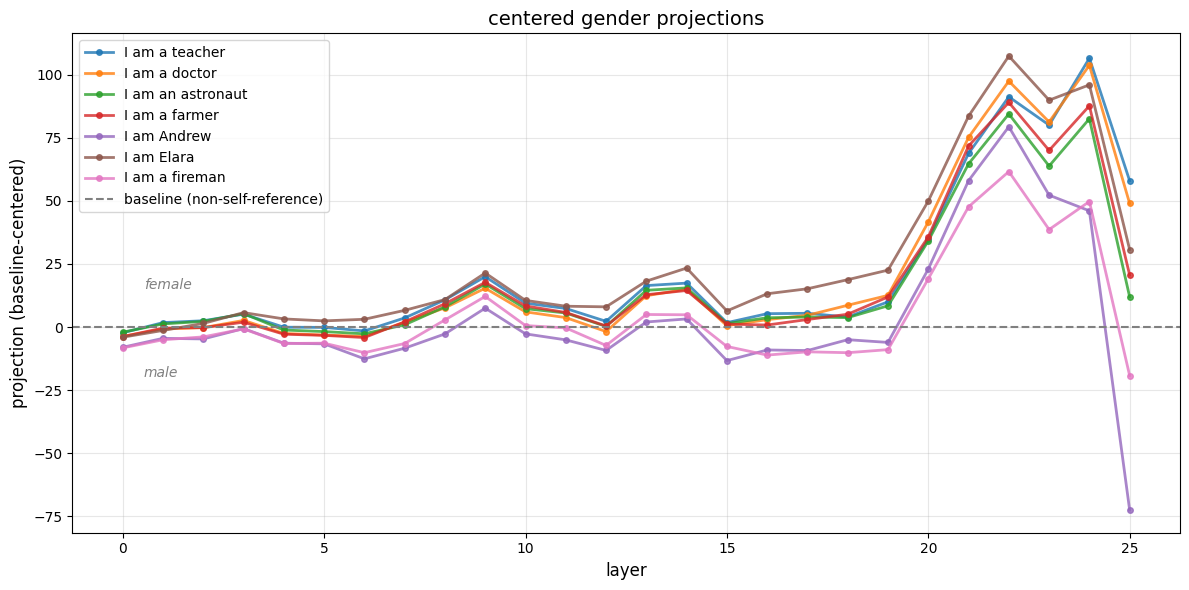

In [31]:
role_centered = {prompt: {} for prompt in role_prompts}

for layer in range(num_layers):
    baseline = non_self_reference_projections[layer]

    for prompt in role_prompts:
        role_centered[prompt][layer] = role_projections[layer][prompt] - baseline

layers = list(range(num_layers))
plt.figure(figsize=(12, 6))

for prompt in role_prompts:
    vals = [role_centered[prompt][layer] for layer in layers]
    plt.plot(layers, vals, marker='o', linewidth=2, markersize=4, label=prompt, alpha=0.8)

plt.axhline(y=0, color='gray', linestyle='--', label='baseline (non-self-reference)')
plt.text(num_layers * 0.02, -20, 'male', fontsize=10, color='gray', style='italic')
plt.text(num_layers * 0.02, 15, 'female', fontsize=10, color='gray', style='italic')
plt.xlabel('layer', fontsize=12)
plt.ylabel('projection (baseline-centered)', fontsize=12)
plt.title('centered gender projections', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## this looks a lot more appropriate! "Andrew" and "fireman" (directly, obviously male designations) are on the male side.
## meanwhile, we do still see that every more "implicitly" gendered role is female, which might suggest that the model activates
## more femininely when self-describing, unless we supply an explicitly male input.
## to investigate the possibility that "helpful assistant-ness" confounds with femininity, i want to try prefills that stand counter to that concept

processing sentiment: I am a murderer
processing sentiment: I am going to refuse
processing sentiment: I am not fond of you
processing sentiment: I am full of joy


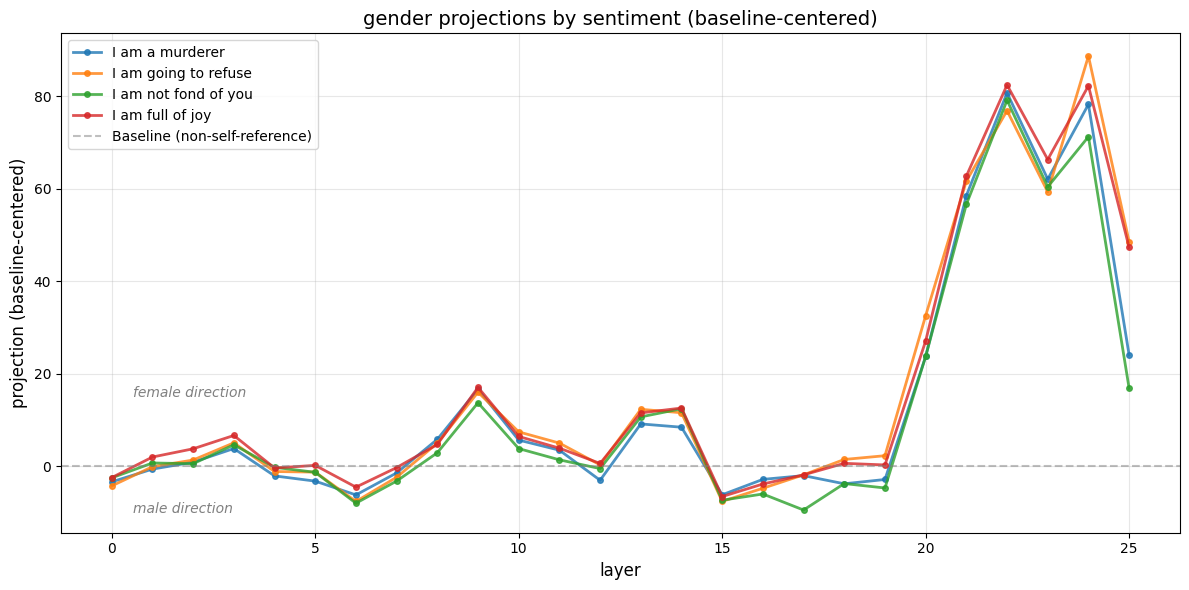

In [33]:
sentiment_prompts = [
    "I am a murderer",
    "I am going to refuse", 
    "I am not fond of you",
    "I am full of joy"
]

sentiment_projections = {layer: {} for layer in range(num_layers)}

for prompt in sentiment_prompts:
    print(f"processing sentiment: {prompt}")
    _, cache = model.run_with_cache(prompt)
    
    for layer in range(num_layers):
        resid = cache[f"blocks.{layer}.hook_resid_post"]
        resid_last = resid[0, -1, :].cpu()
                
        proj = torch.dot(resid_last, gender_vec) / gender_norm
        sentiment_projections[layer][prompt] = proj.item()
    
    del cache
    torch.mps.empty_cache()
    gc.collect()

sentiment_centered = {prompt: {} for prompt in sentiment_prompts}

for layer in range(num_layers):
    baseline = non_self_reference_projections[layer]
    for prompt in sentiment_prompts:
        sentiment_centered[prompt][layer] = sentiment_projections[layer][prompt] - baseline

layers = list(range(num_layers))
plt.figure(figsize=(12, 6))

for prompt in sentiment_prompts:
    vals = [sentiment_centered[prompt][layer] for layer in layers]
    plt.plot(layers, vals, marker='o', linewidth=2, markersize=4, label=prompt, alpha=0.8)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='baseline (non-self-reference)')
plt.text(num_layers * 0.02, -10, 'male', fontsize=10, color='gray', style='italic')
plt.text(num_layers * 0.02, 15, 'female', fontsize=10, color='gray', style='italic')
plt.xlabel('layer', fontsize=12)
plt.ylabel('projection (baseline-centered)', fontsize=12)
plt.title('gender projections by sentiment (baseline-centered)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## it seems like my hypothesis might not be true, based on this data. even the hostile, refusal prefills activate on the feminine side
## i also want to investigate how reference-ness (self-reference, referring to someone else) and pronouns affect actiavation

processing murder prefill: You are a murderer
processing murder prefill: He is a murderer
processing murder prefill: I am a murderer
processing murder prefill: She is a murderer
processing murder prefill: They are a murderer


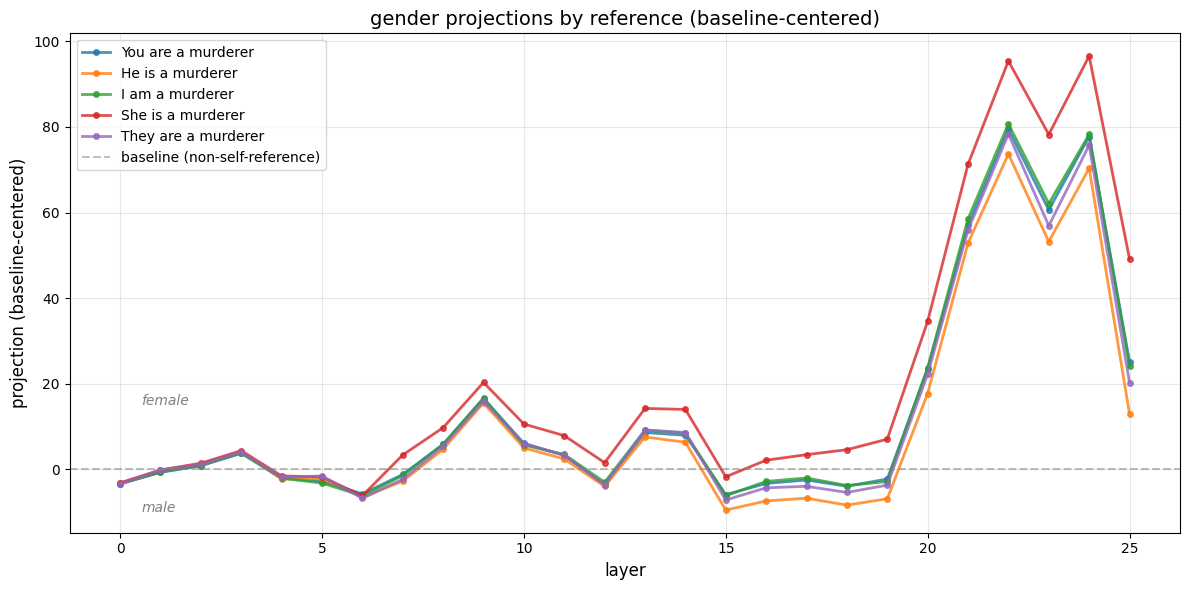

In [34]:
murder_prompts = [
    "You are a murderer",
    "He is a murderer", 
    "I am a murderer",
    "She is a murderer",
    "They are a murderer"
]

murder_projections = {layer: {} for layer in range(num_layers)}

for prompt in murder_prompts:
    print(f"processing murder prefill: {prompt}")
    _, cache = model.run_with_cache(prompt)
    
    for layer in range(num_layers):
        resid = cache[f"blocks.{layer}.hook_resid_post"]
        resid_last = resid[0, -1, :].cpu()
                
        proj = torch.dot(resid_last, gender_vec) / gender_norm
        murder_projections[layer][prompt] = proj.item()
    
    del cache
    torch.mps.empty_cache()
    gc.collect()

murder_centered = {prompt: {} for prompt in murder_prompts}

for layer in range(num_layers):
    baseline = non_self_reference_projections[layer]
    for prompt in murder_prompts:
        murder_centered[prompt][layer] = murder_projections[layer][prompt] - baseline

layers = list(range(num_layers))
plt.figure(figsize=(12, 6))

for prompt in murder_prompts:
    vals = [murder_centered[prompt][layer] for layer in layers]
    plt.plot(layers, vals, marker='o', linewidth=2, markersize=4, label=prompt, alpha=0.8)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='baseline (non-self-reference)')
plt.text(num_layers * 0.02, -10, 'male', fontsize=10, color='gray', style='italic')
plt.text(num_layers * 0.02, 15, 'female', fontsize=10, color='gray', style='italic')
plt.xlabel('layer', fontsize=12)
plt.ylabel('projection (baseline-centered)', fontsize=12)
plt.title('gender projections by reference (baseline-centered)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## these are more readable results--we see that "she is a murderer" is significantly more feminine activating than the other prefills
## and "he is a murderer" is closer to male, but everything is still on the female side. importantly, though, the magnitude of activation
## ***is*** less than it was for the self-reference occupation prefills, which does suggest that femininity is semantically associated with self-reference